In [1]:
install.packages(c("shiny","miniUI","rstudioapi")) #instalowane tu
#pakiety pozwalają na uproszczenie pracy z tidymodels
install.packages("modeldata") #jeśli brakuje - pakiet ze zbiorami danych przykładowych
data(crickets, package = "modeldata")
names(crickets)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



[1] "species" "temp"    "rate"

In [2]:
library(tidyverse)
plot.scale <- 1.5
options(
    jupyter.rich_display = FALSE,
    repr.plot.width = 16/plot.scale,
    repr.plot.height = 9/plot.scale)
ggplot2::theme_set(theme_minimal())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


`geom_smooth()` using formula = 'y ~ x'


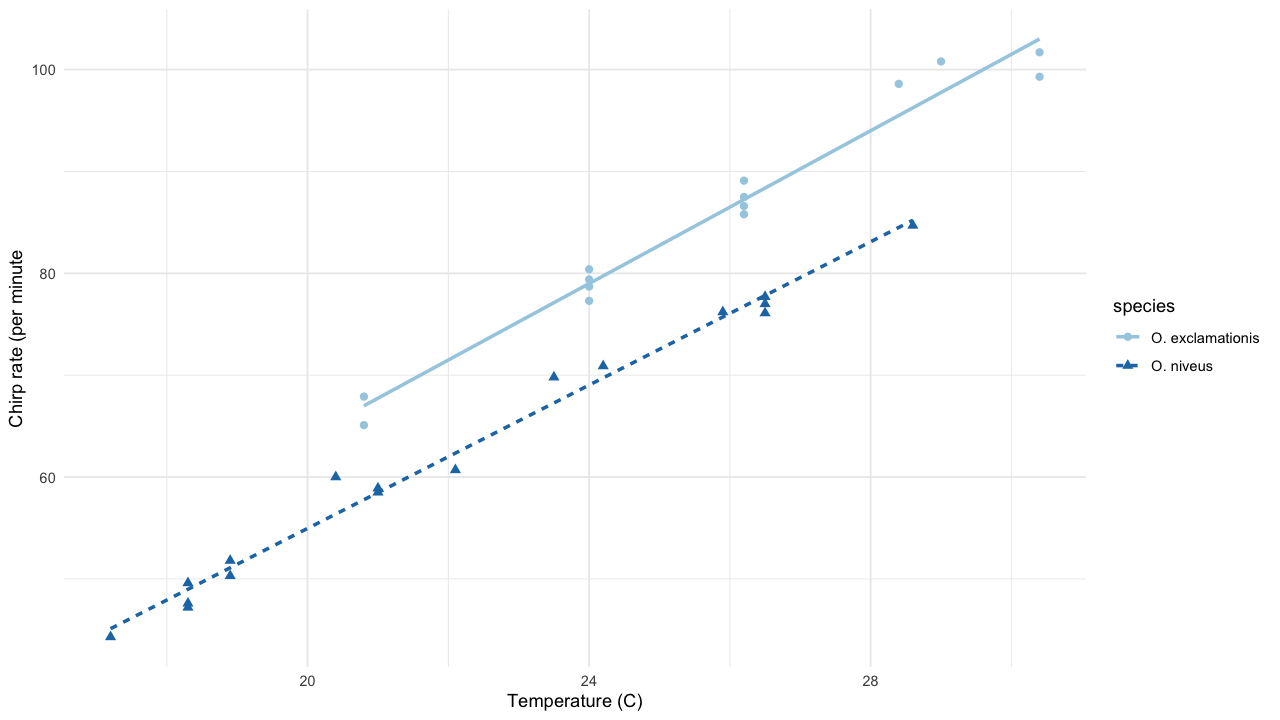

In [3]:
#ODŚWIEŻENIE KROKÓW MODELOWANIA
#dla dobrania modelu interesuje nas charakter związku
#między zmiennymi. Do oceny tego związku często służy wizualizacja.
crickets %>% 
  ggplot(aes(x=temp, y=rate, color=species, pch=species,
             lty=species))+
  geom_point(size=2)+
  geom_smooth(method = lm, se=F, alpha=0.5)+
  scale_color_brewer(palette = "Paired")+
  labs(x="Temperature (C)", y="Chirp rate (per minute")
#wykres wskazuje na liniową zależność stąd niżej dopasujemy
#model regresji liniowej

In [4]:
#standardowe ('base'owe')funkcje do modeli liniowych
lm(rate~temp, data=crickets) #zapis formuły (z tyldą), jeden predyktor


Call:
lm(formula = rate ~ temp, data = crickets)

Coefficients:
(Intercept)         temp  
    -27.948        4.243  


In [5]:
lm(rate~temp+species, data=crickets) # dwa predyktory, tylko efekty główne (bez interakcji)


Call:
lm(formula = rate ~ temp + species, data = crickets)

Coefficients:
     (Intercept)              temp  speciesO. niveus  
          -7.211             3.603           -10.065  


In [6]:
lm(rate~temp+species+temp:species, data=crickets) #efekty główne + interakcja tem i species


Call:
lm(formula = rate ~ temp + species + temp:species, data = crickets)

Coefficients:
          (Intercept)                   temp       speciesO. niveus  
              -11.041                  3.751                 -4.348  
temp:speciesO. niveus  
               -0.234  


In [7]:
lm(rate~temp*species, data=crickets) #inny sposób zapisu tego, co wyżej (efekty główne plus interakcja)


Call:
lm(formula = rate ~ temp * species, data = crickets)

Coefficients:
          (Intercept)                   temp       speciesO. niveus  
              -11.041                  3.751                 -4.348  
temp:speciesO. niveus  
               -0.234  


In [8]:
interaction_fit <- lm(rate~(temp+species)^2, data=crickets)
interaction_fit #zazwyczaj zapisujemy model do obiektu, by...


Call:
lm(formula = rate ~ (temp + species)^2, data = crickets)

Coefficients:
          (Intercept)                   temp       speciesO. niveus  
              -11.041                  3.751                 -4.348  
temp:speciesO. niveus  
               -0.234  


In [ ]:

par(mfrow=c(1,2))
plot(interaction_fit, which=1) #korzystać z poszczególnych jego elementów
plot(interaction_fit, which=2)
summary(interaction_fit) #i też najczęściej by wyświetlić podsumowanie modelu

#sposób na porównanie jakości modeli (tu: bez interakcji, z interakcją) za pomocą analizy wariancji
main_effect_fit <- lm(rate~temp+species, data=crickets)
anova(main_effect_fit,interaction_fit)
summary(main_effect_fit)

#w jaki sposób, mając dopasowany model możemy przewidywać wartości niezaobserwowane empirycznie
new_values <- data.frame(species = "O. exclamationis", temp = 15:20)
predict(main_effect_fit, new_values)

#pierwsza istotna różnica w dostępie do wyników pomiędzy
#modelami w R base, a tidymodels: pakiet broom i funkcja tidy()
corr_res <- map(mtcars %>% select(-mpg), cor.test, y = mtcars$mpg)
corr_res[[1]]
library(broom)
tidy(corr_res[[1]])

corr_res %>% 
  # przekształcamy każdą korelację w format tidy i łączymy w jedną ramkę danych za pomocą map_dfr() 
  map_dfr(tidy, .id = "predictor") %>% 
  ggplot(aes(x = fct_reorder(predictor, estimate))) + 
  geom_point(aes(y = estimate)) + 
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = .1) +
  labs(x = NULL, y = "Correlation with mpg")

#PO CO STOSOWAĆ TIDYMODELS?
# 1. zgodność z filozofią i niektórymi narzędziami tidyverse
# 2. operacje na tibbles - standaryzacja wyników funkcji
#i ułatwienie ich dalszego przetwarzania (np. wizualizacji)
# 3. prostszy i bardziej zrozumiały kod -> szybsza praca, mniej błędów
# 4. standaryzacja całych procesów, do tej pory
#porozrzucanych po różnych pakietach i funkcjach


install.packages("tidymodels")
install.packages("rlang") # fakultatywnie w przypadku nieobsługiwanej wersji
install.packages("cli") # jak wyżej
library(tidymodels)
tidymodels_prefer() #dzięki tej funkcji możemy wymusić
#sposób rozwiązywania konfliktów z funkcjami z innych pakietów
#po co? upraszcza to kod

#praca z tidymodels - parsnip (element metapakietu)
#3 KROKI:
#1 określenie rodzaju potrzebnego modelu (eksploracja!)
#2 określenie silnika modelu i czasami trybu działania (set_mode)
library(tidymodels)
tidymodels_prefer()

linear_reg() %>% 
  set_engine("lm")
#jak to działa?
linear_reg() %>% 
  set_engine("lm") %>% translate() #translate daje nam dostęp do tradycyjnego zapisu formuły modelu

#zmieniając jeden argument zmieniamy silnik (funkcje, ich zapis etc.) działający w tle, a sam kod prawie się nie zmienia
linear_reg() %>% 
  set_engine("stan") %>% translate()
#3 użycie funkcji dopasowania modelu
lm.model.1 <- 
  linear_reg() %>%
  set_engine("lm") #zapisuję silnik / ustawienia do obiektu

#podejrzyjmy dane ames
View(ames)

model.1.fit <- 
  lm.model.1 %>% #aplikuję zapisany (wybrany uprzednio) silnik
  fit(Sale_Price~Longitude+Latitude, data=ames) #wystandaryzowana funkcja dopasowania fit()

model.1.fit

#można to opakować w starą, znaną formatkę za pomocą summary()
model.1.fit %>% 
  extract_fit_engine() %>% #ale musimy wydobyć wyniki za pomocą tej funkcji
  summary()

#ale lepiej:
tidy(model.1.fit)
#i każdy model bez względu na silnik etc. będzie tak prezentowany

#przewidywanie
ames_small <- ames %>% slice(1:8)
predict(model.1.fit, new_data = ames_small) #przewidujemy wartości na podstawie modelu

ames_small %>% 
  select(Sale_Price) %>% 
  bind_cols(predict(model.1.fit, ames_small)) %>% #wyniki modelu, w tym przypadku wartości...
  bind_cols(predict(model.1.fit, ames_small, type = "pred_int"))#... i dodatkowo przedziały predykcji dla tych wartości 
#lub za pomocą mutate + predict można te prognozy połączyć z wyjściowym zbiorem danych, co jest bardzo wygodne

parsnip_addin() #no i nie trzeba wszystkiego pamiętać!
#pakiet zawiera apkę podpowiadającą jakie modele możemy dopasować

#ZADANIE
getwd()
library(tidymodels)
library(tidyverse)
tidymodels_prefer()

#uwaga! własna ścieżka dostępu!
baza1 <- read_csv("~/AGH/Dydaktyka/Analiza danych w R/Dane/pracownicy KUL.csv",
                  col_names = F, skip = 1)
glimpse(baza1)
nazwy <- slice(baza1,1)

#przygotowanie zmiennych
baza1 <- 
  baza1 %>% 
  mutate(output=case_match(X102,
                           c("1. Niska satysfakcja",
                             "2","3","4","5")~"Niskie", 
                           c("6","7. Wysoka satysfakcja")~"Wysokie",
                           .default = NA)) %>% 
  mutate(output=factor(output), plec=X190, wiek=2024-X191, dydakt=X11)

#chcę zrobić regresję logistyczną
levels(baza1$output) #sprawdzam jaki jest porządek wartości czynnika, bo pierwszy jest zawsze wyłączony (brak efektu itp.)

parsnip_addin() #wybieram model glm

log_reg_m1 <-
  logistic_reg() %>%
  set_engine('glm')

model1 <- 
  log_reg_m1 %>% 
  fit(output~1, data=baza1) # tworzę model bazowy - bez predyktorów
#by móc porównywać kolejne modele również do takiego "zerowego" modelu

model1 %>% 
  extract_fit_engine() %>% 
  summary() #wyświetlam wyniki modelu tak...

tidy(model1) #lub tak

#tworzę kolejne, bardziej złożone modele
model2 <- log_reg_m1 %>% 
  fit(output~plec+wiek, data=baza1)

model2 %>% 
  extract_fit_engine() %>% 
  summary()

#w celu porównania modeli ze sobą tworzę obiekt rozpoznawalny
#przez funkcję anova
m1 <- model1 %>% 
  extract_fit_engine()

m2 <- model2 %>% 
  extract_fit_engine()

anova(m1, m2, test="LR") #porównanie modeli. Argument "LR" potrzebny w przypadku modelu regresji logistycznej

#zmienne do wyboru 

#x190 Płeć
#x191 Rok urodzenia
#x193 Najwyższy posiadany stopień / tytuł naukowy
#x11 Czy prowadzi zajęcia dydaktyczne
#x102 satysfakcja

#tworzę brakującą zmienną
baza1 <- 
  baza1 %>% 
  mutate(stopien=case_match(X193,"Doktor"~"Doktor", 
                            "Doktor habilitowany"~"Hab",
                            "Profesor"~"Prof",
                            .default = "Bez stopnia")) %>% 
  mutate(stopien=factor(stopien))

levels(baza1$stopien)

#kolejny model
model3 <- 
  log_reg_m1 %>% 
  fit(output~plec+stopien+dydakt+wiek, data=baza1)

wyniki <- tidy(model3) #na tym przykładzie dobrze widać
#dlaczego fajnie mieć wyniki modelu w ramce danych (tibble)

wyniki[4,2] #bo mogę korzystać z jej elementów za pomocą
#prostych selektorów, nie znając nazw list, wektorów itp. 
#tworzonych i wykorzystywanych w obrębie funkcji
exp(wyniki[4,2] #interpretacja w kategoriach ilorazu szans

m3 <- model3 %>% 
  extract_fit_engine()

anova(m2,m3, test="LR")
